## Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2 
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model
from math import sqrt
from sklearn.metrics import mean_squared_error
import yfinance
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Data 

In [2]:
data = yfinance.download (tickers = "BTC-USD, ETH-USD", interval = "1d", group_by = 'ticker', 
                          auto_adjust = True, threads = True)

[*********************100%***********************]  2 of 2 completed


In [3]:
df = data.copy()
#copy data for ease of use 

In [4]:
# check for missing values
df.isna().sum()

Ticker   Price 
ETH-USD  Open      1149
         High      1149
         Low       1149
         Close     1149
         Volume    1149
BTC-USD  Open         0
         High         0
         Low          0
         Close        0
         Volume       0
dtype: int64

In [5]:
df.head()

Ticker     ETH-USD                           BTC-USD                          \
Price         Open High Low Close Volume        Open        High         Low   
Date                                                                           
2014-09-17     NaN  NaN NaN   NaN    NaN  465.864014  468.174011  452.421997   
2014-09-18     NaN  NaN NaN   NaN    NaN  456.859985  456.859985  413.104004   
2014-09-19     NaN  NaN NaN   NaN    NaN  424.102997  427.834991  384.532013   
2014-09-20     NaN  NaN NaN   NaN    NaN  394.673004  423.295990  389.882996   
2014-09-21     NaN  NaN NaN   NaN    NaN  408.084991  412.425995  393.181000   

Ticker                            
Price            Close    Volume  
Date                              
2014-09-17  457.334015  21056800  
2014-09-18  424.440002  34483200  
2014-09-19  394.795990  37919700  
2014-09-20  408.903992  36863600  
2014-09-21  398.821014  26580100

In [6]:
#backfill missing values
df = df.bfill()

In [7]:
df.isna().sum()

Ticker   Price 
ETH-USD  Open      0
         High      0
         Low       0
         Close     0
         Volume    0
BTC-USD  Open      0
         High      0
         Low       0
         Close     0
         Volume    0
dtype: int64

In [8]:
#Creating new Columns for returns, log returns, and their squares 
df['BTC_close'] = df['BTC-USD']['Close']
df['ETH_close'] = df['ETH-USD']['Close']

df['BTC_returns'] = df['BTC_close'].pct_change(1).mul(100)
df['ETH_returns'] = df['ETH_close'].pct_change(1).mul(100)

df['BTC_log_returns'] = np.log(1 + df['BTC_close'].pct_change())
df['ETH_log_returns'] = np.log(1 + df['ETH_close'].pct_change())

df['BTC_sq_returns'] = df['BTC_returns'].pow(2)
df['ETH_sq_returns'] = df['ETH_returns'].pow(2)

df['BTC_sq_log_returns'] = df['BTC_log_returns'].pow(2)
df['ETH_sq_log_returns'] = df['ETH_log_returns'].pow(2)


In [9]:
df["BTC_returns"] = df["BTC_returns"].dropna()
df["ETH_returns"] = df["ETH_returns"].dropna()

df["BTC_log_returns"] = df["BTC_log_returns"].dropna()
df["ETH_log_returns"] = df["ETH_log_returns"].dropna()

df["BTC_sq_returns"] = df["BTC_sq_returns"].dropna()
df["ETH_sq_returns"] = df["ETH_sq_returns"].dropna()

df["BTC_sq_log_returns"] = df["BTC_sq_log_returns"].dropna()
df["ETH_sq_log_returns"] = df["ETH_sq_log_returns"].dropna()

In [10]:
#start date uses approximately 1.5 years of data for more recent market behavior
#this also helps to eliminate outliers in the data, like the covid crash 
start = '2025-01-01'
end = '2025-07-25'
#Should their be an end date? yes we should make end= "2025-07-25" or 24 to make this work and add end everywhere you see start:

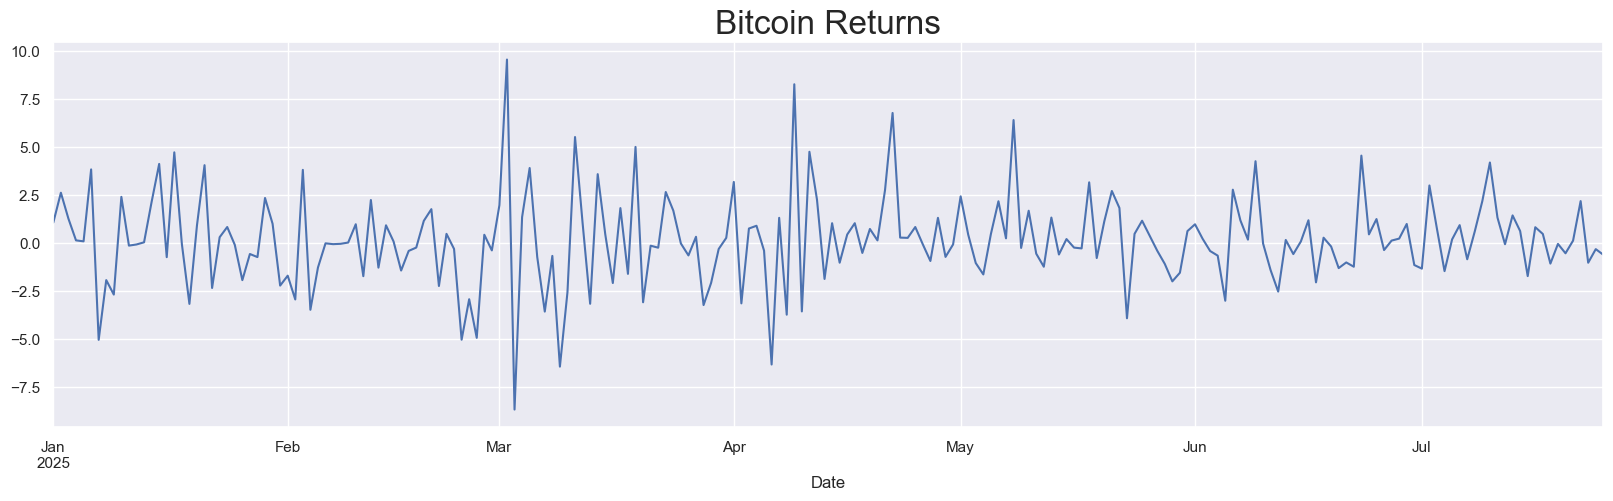

In [11]:
df.BTC_returns[start:end].plot(figsize = (20,5))
plt.title("Bitcoin Returns", size = 24)
plt.show()

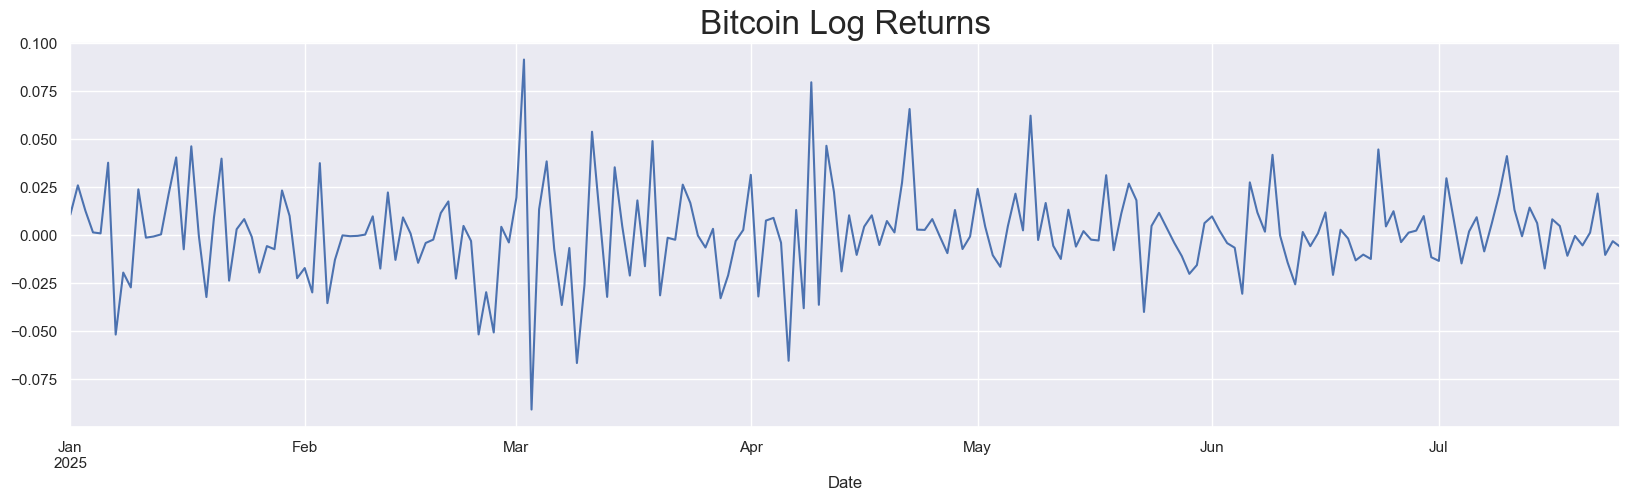

In [12]:
df.BTC_log_returns[start:end].plot(figsize = (20,5))
plt.title("Bitcoin Log Returns", size = 24)
plt.show()

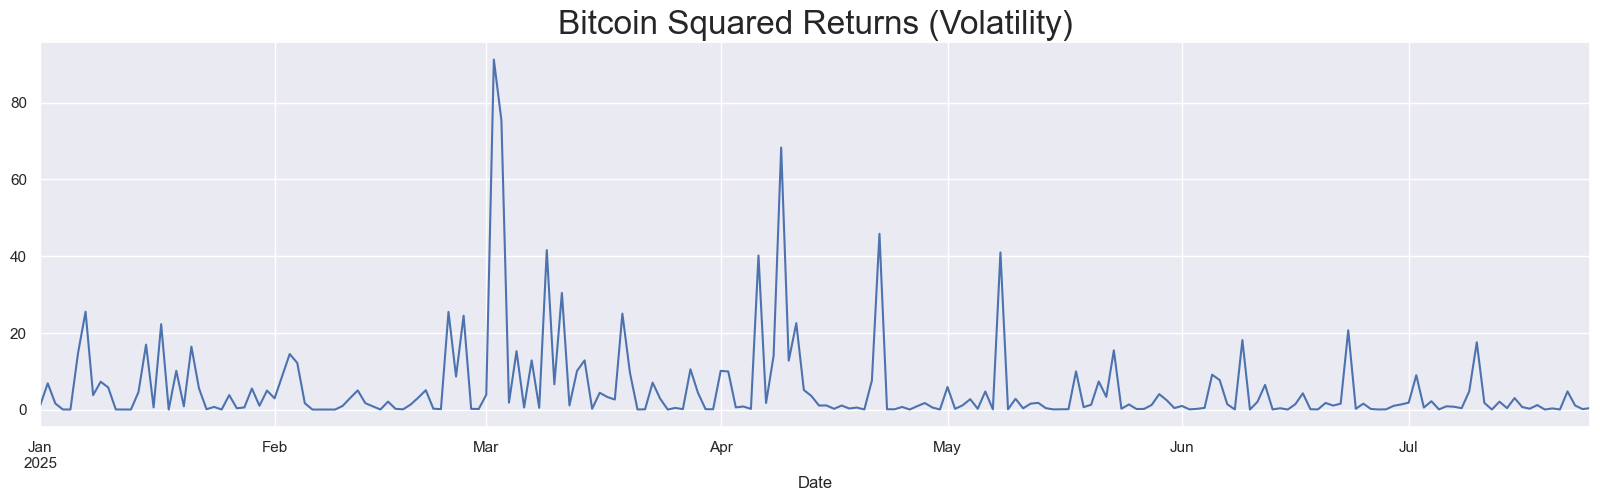

In [13]:
df["BTC_sq_returns"][start:end].plot(figsize = (20,5))
plt.title("Bitcoin Squared Returns (Volatility)", size = 24)
plt.show()

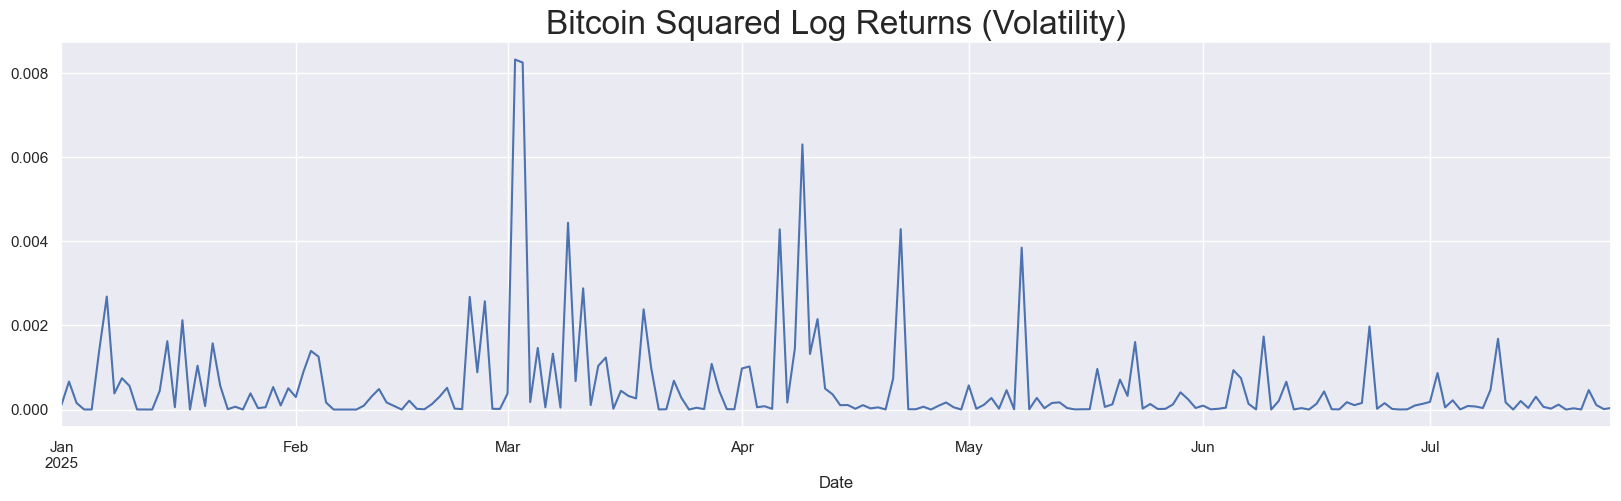

In [14]:
df.BTC_sq_log_returns[start:end].plot(figsize = (20,5))
plt.title("Bitcoin Squared Log Returns (Volatility)", size = 24)
plt.show()

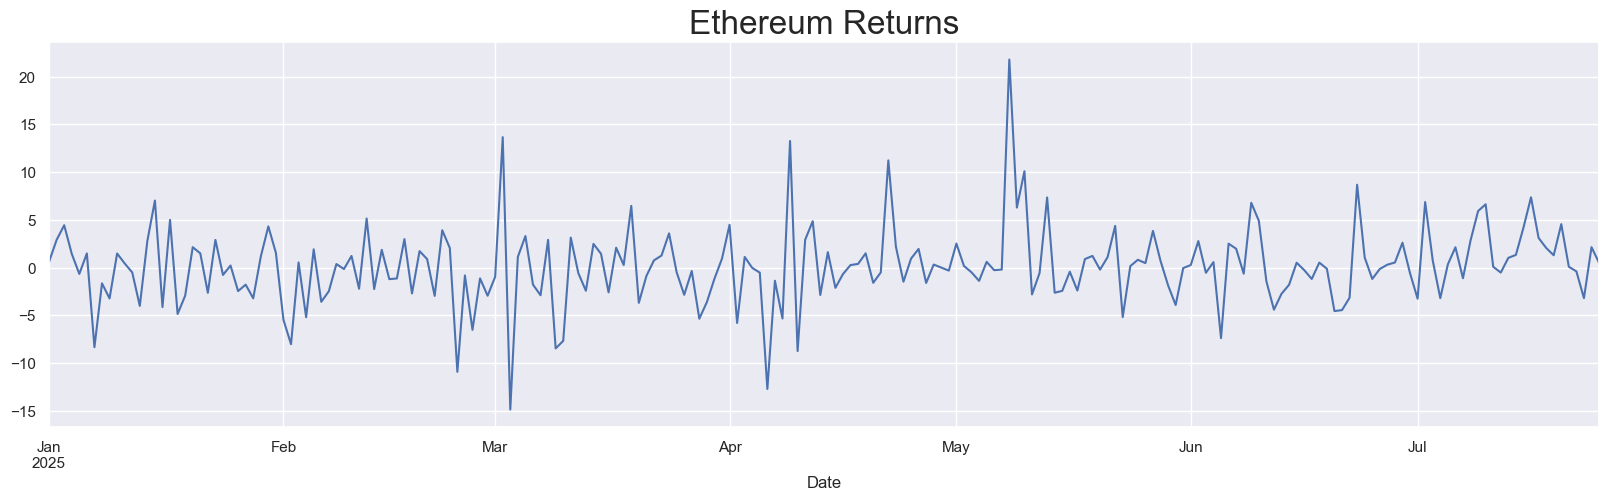

In [15]:
df.ETH_returns[start:end].plot(figsize = (20,5))
plt.title("Ethereum Returns", size = 24)
plt.show()

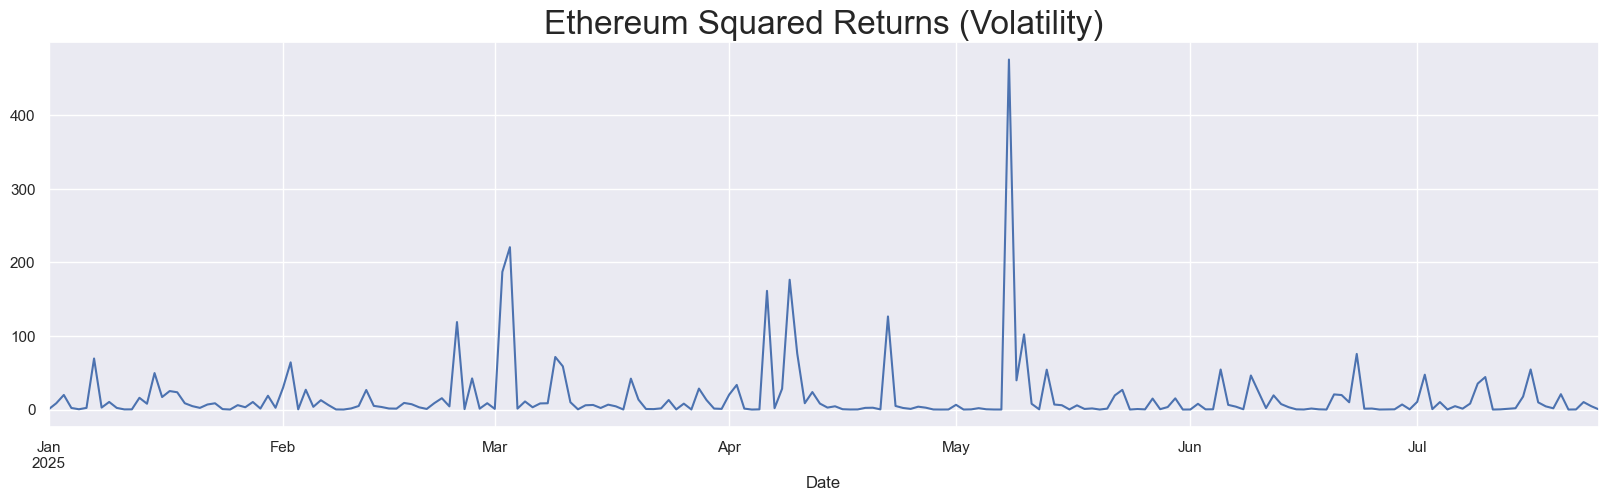

In [16]:
df.ETH_sq_returns[start:end].plot(figsize = (20,5))
plt.title("Ethereum Squared Returns (Volatility)", size = 24)
plt.show()

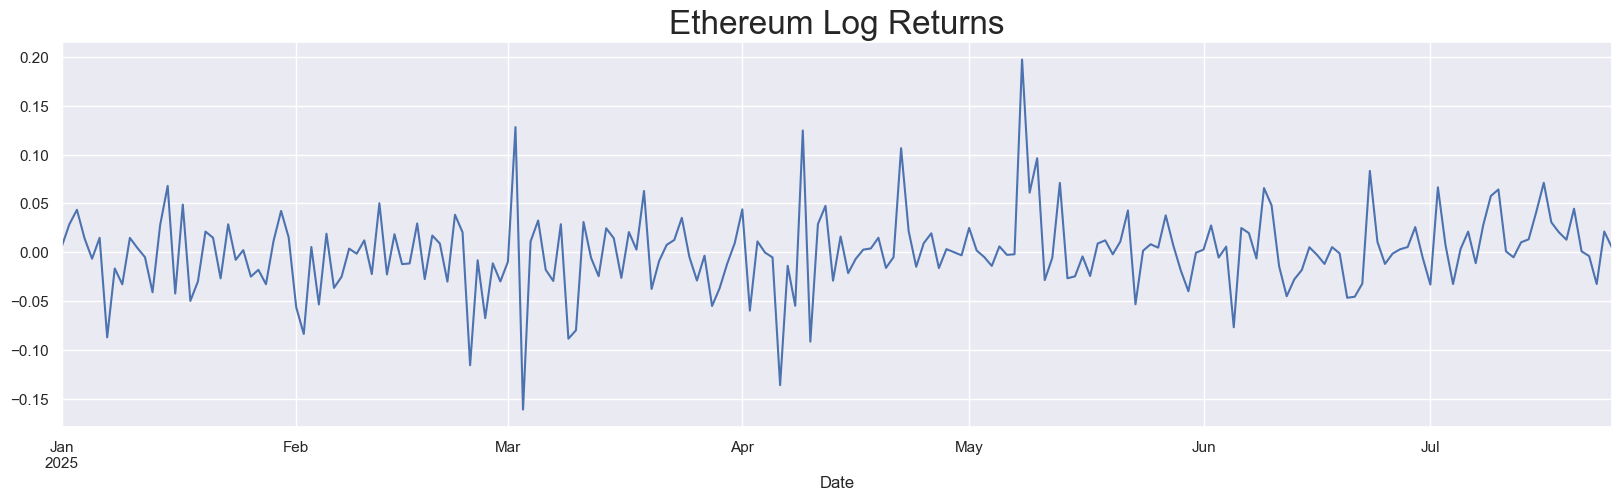

In [17]:
df.ETH_log_returns[start:end].plot(figsize = (20,5))
plt.title("Ethereum Log Returns", size = 24)
plt.show()

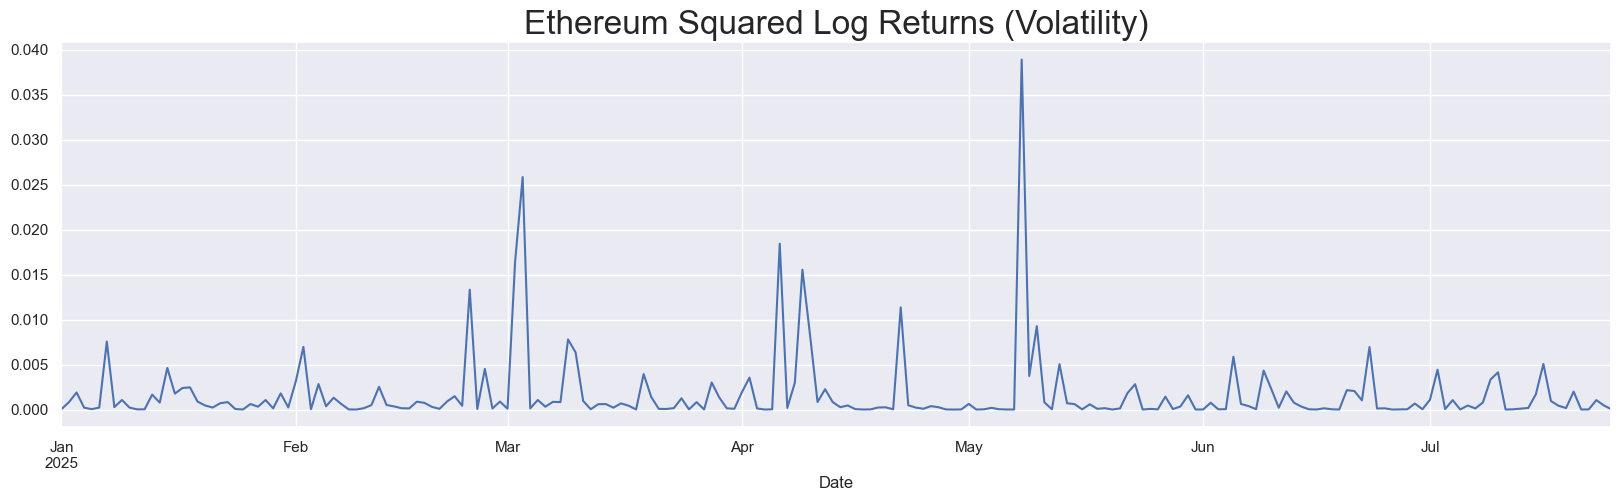

In [18]:
df.ETH_sq_log_returns[start:end].plot(figsize = (20,5))
plt.title("Ethereum Squared Log Returns (Volatility)", size = 24)
plt.show()

## Stationarity Testing 

In [19]:
#ARCH and GARCH models require variance to be stationary rather than mean 
#applying Augmented Dickey Fuller Test 
sts.adfuller(df.BTC_returns[start:end])

(-16.56074195937868,
 1.9082487250952422e-29,
 0,
 205,
 {'1%': -3.4626576734812318,
  '5%': -2.8757444215841326,
  '10%': -2.5743412314098753},
 865.2896124132258)

In [20]:
sts.adfuller(df.ETH_returns[start:end])

(-15.05684449141791,
 9.123930407078562e-28,
 0,
 205,
 {'1%': -3.4626576734812318,
  '5%': -2.8757444215841326,
  '10%': -2.5743412314098753},
 1087.3265885662813)

In [21]:
sts.adfuller(df.BTC_log_returns[start:end])

(-16.54600869243553,
 1.9643760871098246e-29,
 0,
 205,
 {'1%': -3.4626576734812318,
  '5%': -2.8757444215841326,
  '10%': -2.5743412314098753},
 -886.0813459523879)

In [22]:
sts.adfuller(df.ETH_log_returns[start:end])

(-15.134246243249446,
 7.159515867073917e-28,
 0,
 205,
 {'1%': -3.4626576734812318,
  '5%': -2.8757444215841326,
  '10%': -2.5743412314098753},
 -666.4527262508799)

In [23]:
sts.adfuller(df.BTC_sq_returns[start:end])

(-11.206952120209671,
 2.1728475052203217e-20,
 0,
 205,
 {'1%': -3.4626576734812318,
  '5%': -2.8757444215841326,
  '10%': -2.5743412314098753},
 1482.9732531705147)

In [24]:
sts.adfuller(df.ETH_sq_returns[start:end])

(-12.71640033696411,
 1.0043240138486365e-23,
 0,
 205,
 {'1%': -3.4626576734812318,
  '5%': -2.8757444215841326,
  '10%': -2.5743412314098753},
 1998.7049496540849)

In [25]:
sts.adfuller(df.BTC_sq_log_returns[start:end])

(-11.109686671889465,
 3.6867156620707887e-20,
 0,
 205,
 {'1%': -3.4626576734812318,
  '5%': -2.8757444215841326,
  '10%': -2.5743412314098753},
 -2024.708034803486)

In [26]:
sts.adfuller(df.ETH_sq_log_returns[start:end])

(-12.529108257347302,
 2.4509977919720035e-23,
 0,
 205,
 {'1%': -3.4626576734812318,
  '5%': -2.8757444215841326,
  '10%': -2.5743412314098753},
 -1532.4878053074922)

In [27]:
# Each New Data Set passes the test and therefore can reject the null hypothesis
# Conclude the data is stationary

## ARCH LM TEST

In [28]:
#ARCH Lagrange Multiplier, checks for Conditional Heteroskedasticity
#reject Null Hypothesis if p-valus is < 0.05 and continue with ARCH Model

test_stat, p_value, _, _ = het_arch(df["BTC_returns"][start:end])
print(f"ARCH LM Test p-value for Bitcoin returns: {p_value}")

ARCH LM Test p-value for Bitcoin returns: 0.1196747642029056


In [29]:
test_stat, p_value, _, _ = het_arch(df["ETH_returns"][start:end])
print(f"ARCH LM Test p-value for ethereum returns: {p_value}")

ARCH LM Test p-value for ethereum returns: 0.8352622702235061


In [30]:
test_stat, p_value, _, _ = het_arch(df["BTC_log_returns"][start:end])
print(f"ARCH LM Test p-value BTC_log_returns: {p_value}")

test_stat, p_value, _, _ = het_arch(df["ETH_log_returns"][start:end])
print(f"ARCH LM Test p-value ETH_log_returns: {p_value}")

test_stat, p_value, _, _ = het_arch(df["BTC_sq_returns"][start:end])
print(f"ARCH LM Test p-value BTC_sq_returns: {p_value}")

test_stat, p_value, _, _ = het_arch(df["ETH_sq_returns"][start:end])
print(f"ARCH LM Test p-value ETH_sq_returns: {p_value}")

test_stat, p_value, _, _ = het_arch(df["BTC_sq_log_returns"][start:end])
print(f"ARCH LM Test p-value BTC_sq_log_returns: {p_value}")

test_stat, p_value, _, _ = het_arch(df["ETH_sq_log_returns"][start:end])
print(f"ARCH LM Test p-value ETH_sq_log_returns: {p_value}")

ARCH LM Test p-value BTC_log_returns: 0.0693484339778485
ARCH LM Test p-value ETH_log_returns: 0.6327902023678087
ARCH LM Test p-value BTC_sq_returns: 0.002656847085781713
ARCH LM Test p-value ETH_sq_returns: 0.9999960174771918
ARCH LM Test p-value BTC_sq_log_returns: 0.00018163747949278959
ARCH LM Test p-value ETH_sq_log_returns: 0.9997445975571063


In [31]:
# from this analysis we can reject the null hypothesis for BTC Squared returns & Sqaured Log returns
# ARCH modeling should not be used for values > 0.05
#Going forward we will not use ETH data because it does not fir the neccessary assumption for ARCH/GARCH modeling

## ACF/PACF Plots for Volatility 

In [32]:
# Because we are looking into modeling volatility, we will only look into ACF/PACF for 
#Returns Squared and Log Returns Squared AKA Volatility 

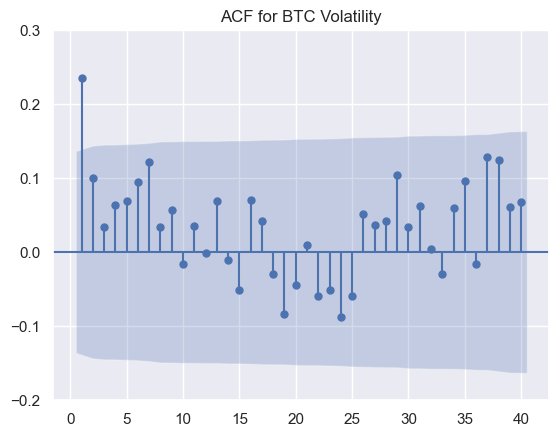

In [33]:
sgt.plot_acf(df.BTC_sq_returns[start:end], zero = False, lags = 40)
plt.title("ACF for BTC Volatility")
plt.ylim(-0.2, 0.3)
plt.show()

#Note: Zero = False excludes the correlation at lag 0 
# lag 0 = 1 always

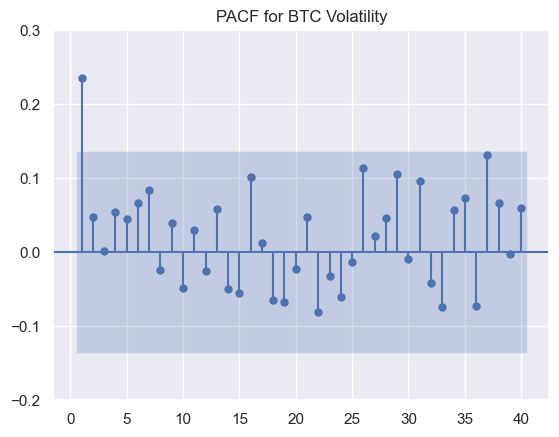

In [34]:
sgt.plot_pacf(df.BTC_sq_returns[start:end], zero = False, lags = 40)
plt.title("PACF for BTC Volatility")
plt.ylim(-0.2, 0.3)
plt.show()

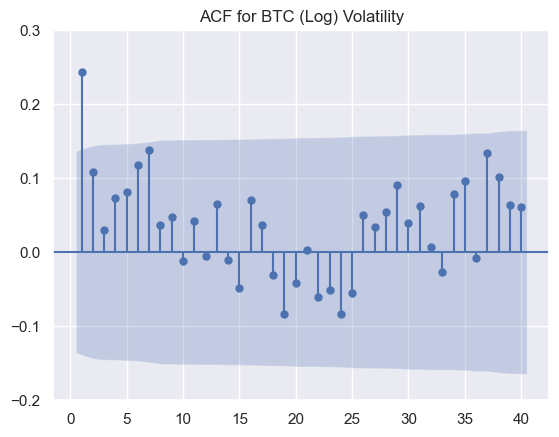

In [35]:
sgt.plot_acf(df.BTC_sq_log_returns[start:end], zero = False, lags = 40)
plt.title("ACF for BTC (Log) Volatility")
plt.ylim(-0.2, 0.3)
plt.show()

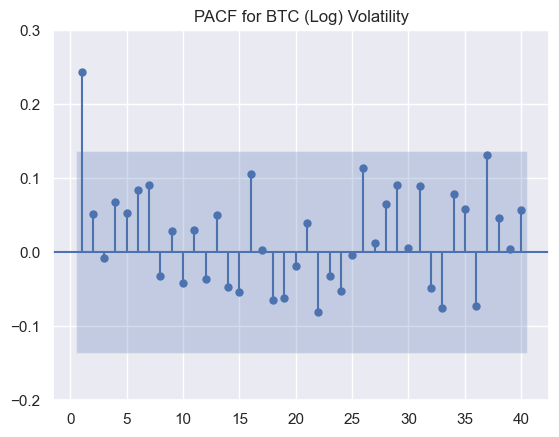

In [36]:
sgt.plot_pacf(df.BTC_sq_log_returns[start:end], zero = False, lags = 40)
plt.title("PACF for BTC (Log) Volatility")
plt.ylim(-0.2, 0.3)
plt.show()

In [37]:
# plots show low signs of auto correlation but LM test was significant so test orders using LLR Test and lowest AIC Values 

## LLR Test function

In [38]:
#will be used to compare simpler model vs a more complex model
# if the result from the test is < 0.05 we contiue with a more complex model

In [40]:
# def LLR_test(mod_1, mod_2, DF = 1):
#    L1 = mod_1.fit(start_ar_lags = 11).llf
#    L2 = mod_2.fit(start_ar_lags = 11).llf
#    LR = (2*(L2-L1))    
#    p = chi2.sf(LR, DF).round(3)
#    return p

#changed LLR Test for ARIMA Models above to fit ARCH/GARCH Model
#disp = off turns the display off from the fitting method
def LLR_test(mod_1, mod_2, DF=1):
    result_1 = mod_1.fit(disp='off')
    result_2 = mod_2.fit(disp='off')
    L1 = result_1.loglikelihood
    L2 = result_2.loglikelihood
    LR = 2 * (L2 - L1)
    p_value = chi2.sf(LR, DF)
    
    return round(p_value, 10)


## BTC ARCH(p) Volatility Models and Comparisons

In [41]:
BTC_arch_1 = arch_model(df.BTC_sq_returns[start:end], mean = "Constant", vol = "ARCH", p =1)
results_BTC_arch_1 = BTC_arch_1.fit(disp = "off")

In [42]:
BTC_arch_2 = arch_model(df.BTC_sq_returns[start:end], mean = "Constant", vol = "ARCH", p =2)
results_BTC_arch_2 = BTC_arch_2.fit(disp= "off")

In [43]:
print("LLR Test Results for ARCH(1) and ARCH(2): " + str(LLR_test(BTC_arch_1,BTC_arch_2)))

LLR Test Results for ARCH(1) and ARCH(2): 0.6640926828


In [44]:
# we can stop here because we show no statistical improvement from ARCH(1) to ARCH(2)
# additionally the results from ARCH(1) had a lower AIC/BIC value suggesting a better fit with fewer parameters

In [45]:
# Summary for ARCH(1) Model

In [46]:
results_BTC_arch_1

                      Constant Mean - ARCH Model Results                      
Dep. Variable:         BTC_sq_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -790.806
Distribution:                  Normal   AIC:                           1587.61
Method:            Maximum Likelihood   BIC:                           1597.60
                                        No. Observations:                  206
Date:                Sun, Jul 27 2025   Df Residuals:                      205
Time:                        17:46:42   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             5.2093      0.815      6.392  1.635e-10 [  3.612,  6.80

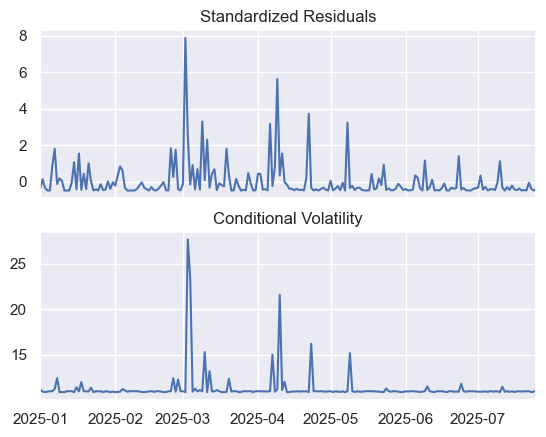

In [47]:
results_BTC_arch_1.plot()
plt.show()

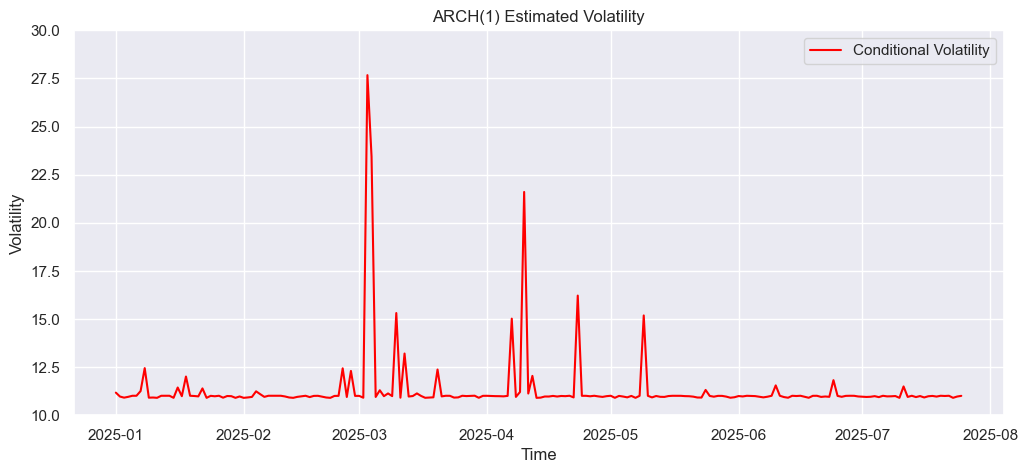

In [48]:
plt.figure(figsize=(12,5))
plt.plot(results_BTC_arch_1.conditional_volatility, color='red', label='Conditional Volatility')
plt.title('ARCH(1) Estimated Volatility')
plt.ylim(10,30)
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()


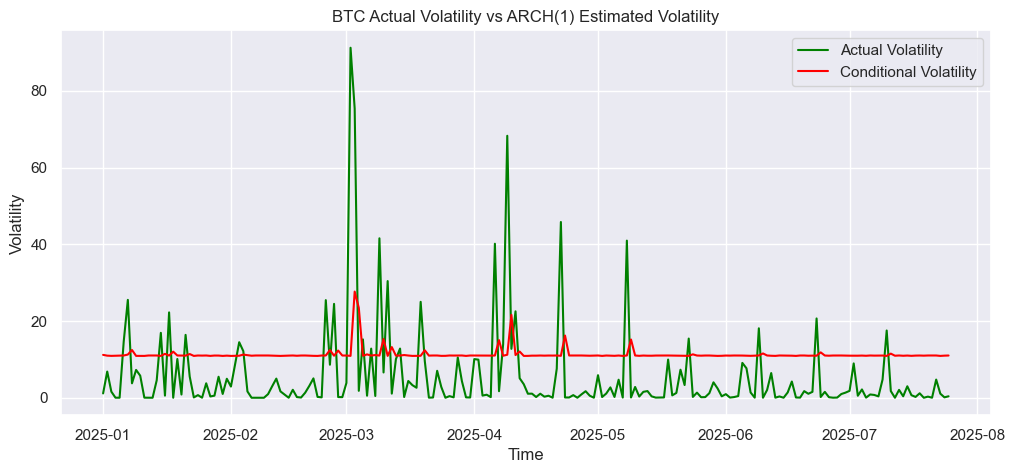

In [51]:
plt.figure(figsize=(12,5))
plt.plot(df.BTC_sq_returns[start:end], color='green', label='Actual Volatility')
plt.plot(results_BTC_arch_1.conditional_volatility, color='red', label='Conditional Volatility')
plt.title('BTC Actual Volatility vs ARCH(1) Estimated Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
# Model predicts spikes in volatility well but fails to match the amplitude of the actual Data 
# could still be very useful but just multipling by a constant

## BTC ARCH(p) Log Volatility Models and Comparisons

In [55]:
BTC_log_arch_1 = arch_model(df.BTC_sq_log_returns[start:end], mean = "Constant", vol = "ARCH", p =1)
results_BTC_log_arch_1 = BTC_log_arch_1.fit(disp = "off")

C:\Users\jcush\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [56]:
BTC_log_arch_2 = arch_model(df.BTC_sq_log_returns[start:end], mean = "Constant", vol = "ARCH", p =2)
results_BTC_log_arch_2 = BTC_log_arch_2.fit(disp = "off")

In [64]:
LLR_test(BTC_log_arch_1,BTC_log_arch_2)

C:\Users\jcush\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


0.0

In [65]:
BTC_log_arch_3 = arch_model(df.BTC_sq_log_returns[start:end], mean = "Constant", vol = "ARCH", p =3)
results_BTC_log_arch_3 = BTC_log_arch_3.fit(disp = "off")

In [66]:
LLR_test(BTC_log_arch_2,BTC_log_arch_3)

0.0019859517

In [67]:
BTC_log_arch_4 = arch_model(df.BTC_sq_log_returns[start:end], mean = "Constant", vol = "ARCH", p =4)
results_BTC_log_arch_4 = BTC_log_arch_4.fit(disp = "off")

C:\Users\jcush\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [68]:
LLR_test(BTC_log_arch_3,BTC_log_arch_4)

C:\Users\jcush\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


1.0

In [ ]:
#BTC_log_arch_3 is our best fitting ARCH Model for Log Volatility

In [69]:
results_BTC_log_arch_3

                      Constant Mean - ARCH Model Results                      
Dep. Variable:     BTC_sq_log_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                1118.05
Distribution:                  Normal   AIC:                          -2226.09
Method:            Maximum Likelihood   BIC:                          -2209.45
                                        No. Observations:                  206
Date:                Sun, Jul 27 2025   Df Residuals:                      205
Time:                        17:49:38   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         5.1665e-04  3.066e-08  1.685e+04      0.000 [5.

In [62]:
#similarly, ARCH(3) is the best model by AIC/BIC and LLR Test compared to other more complex models

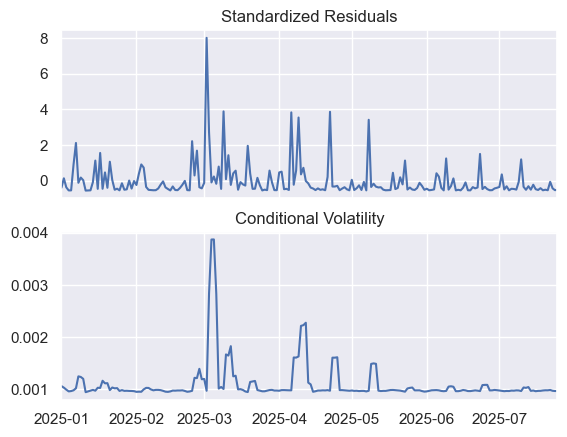

In [70]:
results_BTC_log_arch_3.plot()
plt.show()

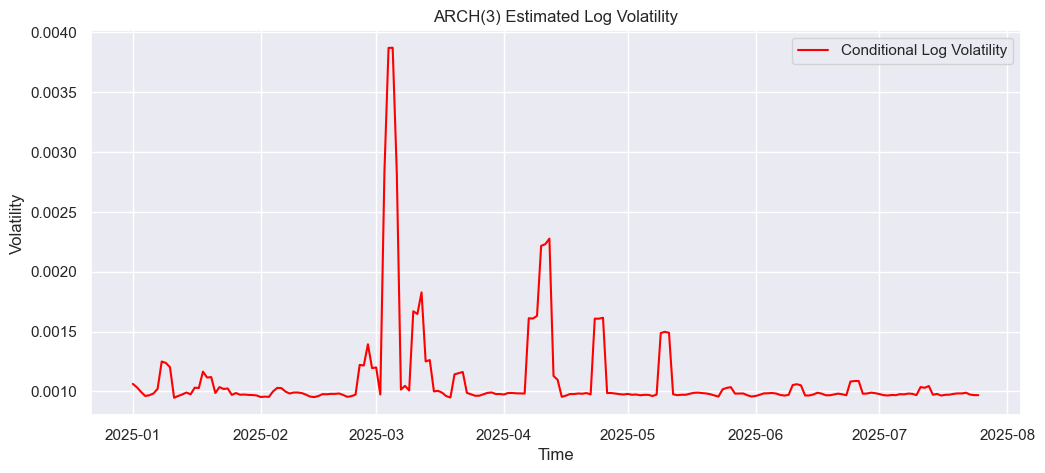

In [71]:
plt.figure(figsize=(12,5))
plt.plot(results_BTC_log_arch_3.conditional_volatility, color='red', label='Conditional Log Volatility')
plt.title('ARCH(3) Estimated Log Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()


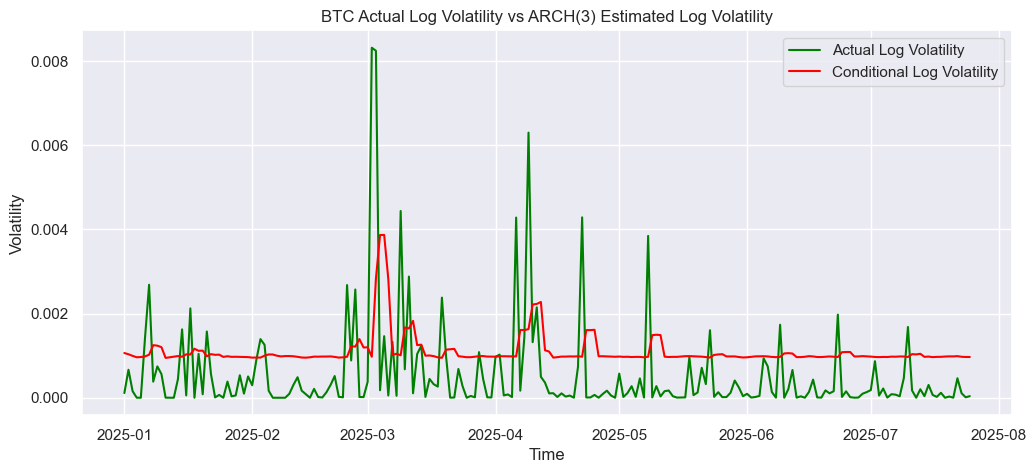

In [72]:
plt.figure(figsize=(12,5))
plt.plot(df.BTC_sq_log_returns[start:end], color='green', label='Actual Log Volatility')
plt.plot(results_BTC_log_arch_3.conditional_volatility, color='red', label='Conditional Log Volatility')
plt.title('BTC Actual Log Volatility vs ARCH(3) Estimated Log Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

## BTC GARCH(p,q) Volatility and Log Volatility Model Comparison

In [ ]:
# Before starting. it has been mathematically proven that no higher order GARCH model 
# outpreforms the GARCH(1,1) when it comes to variance of market returns 
# This is because the effects of the conditional variance 2 days ago are already contained 
# in the conditional variance of yesterday, thus no need to include more than 1 GARCH component

In [73]:
BTC_garch_1_1 = arch_model(df.BTC_sq_returns[start:end], mean = "Constant", vol = "GARCH", p =1, q =1)
results_BTC_garch_1_1 = BTC_garch_1_1.fit(disp = "off")

In [74]:
BTC_garch_2_1 = arch_model(df.BTC_sq_returns[start:end], mean = "Constant", vol = "GARCH", p =2, q =1)
results_BTC_garch_2_1 = BTC_garch_2_1.fit(disp = "off")

In [75]:
results_BTC_garch_1_1

                     Constant Mean - GARCH Model Results                      
Dep. Variable:         BTC_sq_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -779.129
Distribution:                  Normal   AIC:                           1566.26
Method:            Maximum Likelihood   BIC:                           1579.57
                                        No. Observations:                  206
Date:                Sun, Jul 27 2025   Df Residuals:                      205
Time:                        17:52:53   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             4.2660      0.747      5.713  1.111e-08 [  2.802,  5.73

In [76]:
results_BTC_garch_2_1

                     Constant Mean - GARCH Model Results                      
Dep. Variable:         BTC_sq_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -777.337
Distribution:                  Normal   AIC:                           1564.67
Method:            Maximum Likelihood   BIC:                           1581.31
                                        No. Observations:                  206
Date:                Sun, Jul 27 2025   Df Residuals:                      205
Time:                        17:53:00   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             4.4190      0.711      6.215  5.130e-10 [  3.025,  5.81

In [ ]:
# GARCH(1,1) has lower BIC and GARCH(2,1) has lower AIC 

In [77]:
LLR_test(BTC_garch_1_1, BTC_garch_2_1)

0.0583452486

In [78]:
#By LLR test we should use GARCH(1,1) by a very small margin

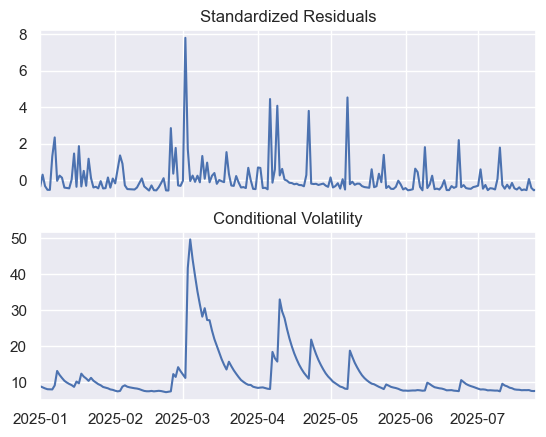

In [79]:
results_BTC_garch_1_1.plot()
plt.show()

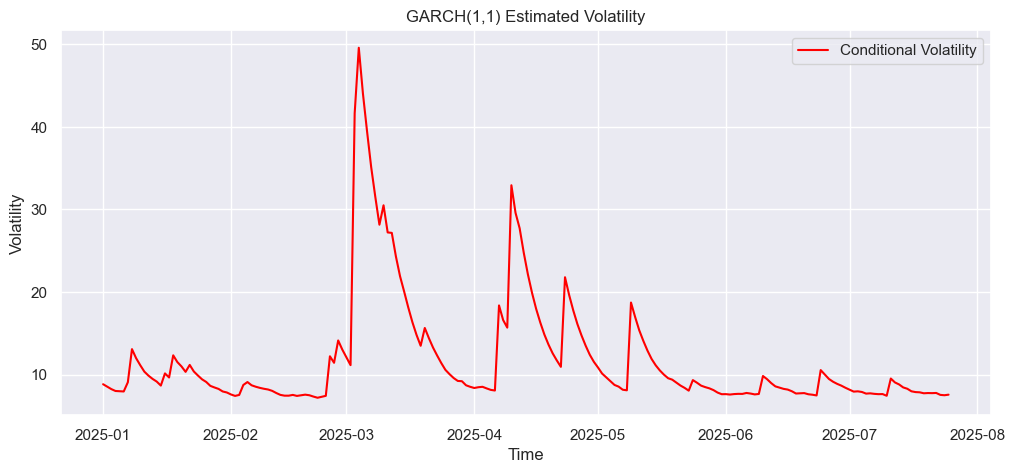

In [80]:
plt.figure(figsize=(12,5))
plt.plot(results_BTC_garch_1_1.conditional_volatility, color='red', label='Conditional Volatility')
plt.title('GARCH(1,1) Estimated Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

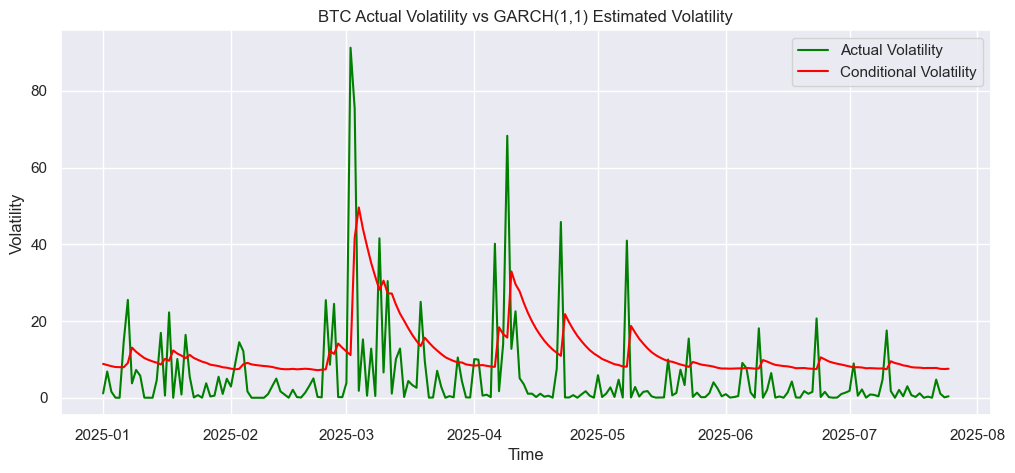

In [81]:
plt.figure(figsize=(12,5))
plt.plot(df.BTC_sq_returns[start:end], color='green', label='Actual Volatility')
plt.plot(results_BTC_garch_1_1.conditional_volatility, color='red', label='Conditional Volatility')
plt.title('BTC Actual Volatility vs GARCH(1,1) Estimated Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

In [88]:
BTC_log_garch_1_1 = arch_model(df.BTC_sq_log_returns[start:end], mean = "Constant", vol = "GARCH", p =1, q =1)
results_BTC_log_garch_1_1 = BTC_log_garch_1_1.fit(disp = "off")

C:\Users\jcush\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [89]:
BTC_log_garch_2_1 = arch_model(df.BTC_sq_log_returns[start:end], mean = "Constant", vol = "GARCH", p =2, q =1)
results_BTC_log_garch_2_1 = BTC_log_garch_2_1.fit(disp = "off")

C:\Users\jcush\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [90]:
LLR_test(BTC_log_garch_1_1, BTC_log_garch_2_1)

C:\Users\jcush\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\jcush\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


1.0

In [91]:
results_BTC_log_garch_1_1

                     Constant Mean - GARCH Model Results                      
Dep. Variable:     BTC_sq_log_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                351.161
Distribution:                  Normal   AIC:                          -694.321
Method:            Maximum Likelihood   BIC:                          -681.010
                                        No. Observations:                  206
Date:                Sun, Jul 27 2025   Df Residuals:                      205
Time:                        17:54:39   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0172  2.988e-07  5.746e+04      0.000 [1.

In [92]:
# from testing GARCH(1,1) has the lowest AIC/BIC values and passed LLR Tests on 7/25/25

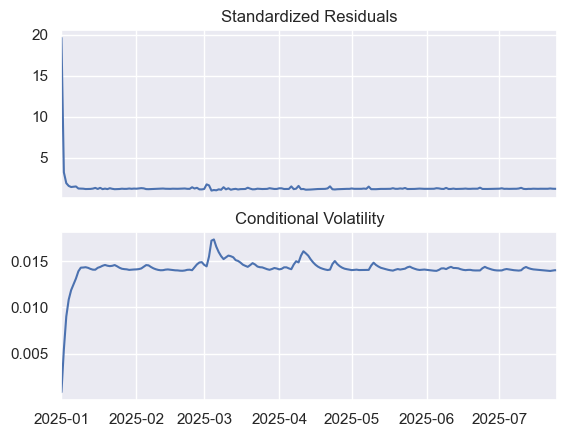

In [93]:
results_BTC_log_garch_2_1.plot()
plt.show()

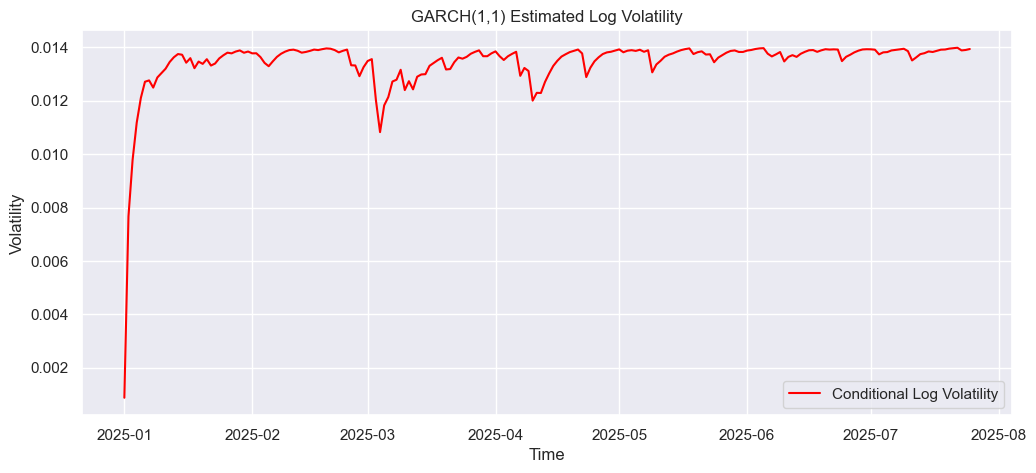

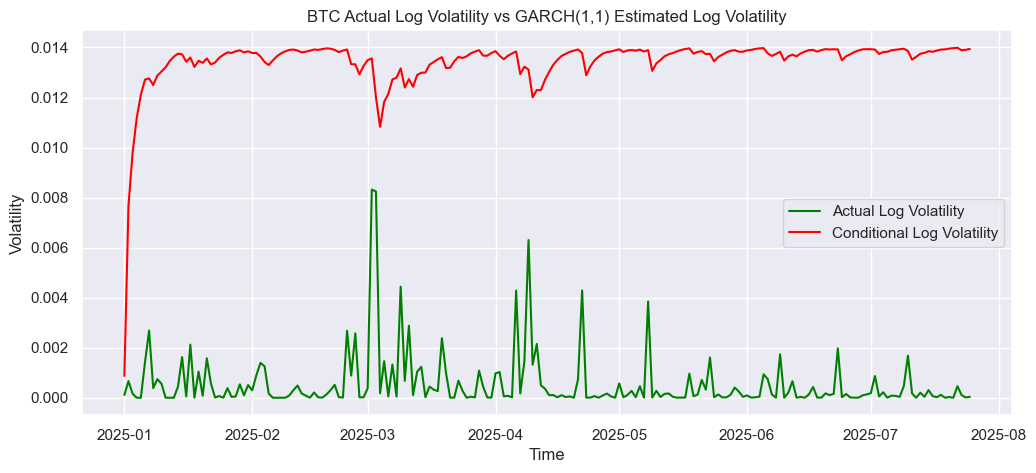

In [94]:
plt.figure(figsize=(12,5))
plt.plot(results_BTC_log_garch_1_1.conditional_volatility, color='red', label='Conditional Log Volatility')
plt.title('GARCH(1,1) Estimated Log Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(df.BTC_sq_log_returns[start:end], color='green', label='Actual Log Volatility')
plt.plot(results_BTC_log_garch_1_1.conditional_volatility, color='red', label='Conditional Log Volatility')
plt.title('BTC Actual Log Volatility vs GARCH(1,1) Estimated Log Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

## Visual Comparisons and MSE (Mean Squared Error)

In [95]:
#Mean Squarred Error Calculation

In [97]:
mse_arch_vol = mean_squared_error(df.BTC_sq_returns[start:end], results_BTC_arch_1.conditional_volatility)
mse_garch_vol = mean_squared_error(df.BTC_sq_returns[start:end], results_BTC_garch_1_1.conditional_volatility)
mse_arch_log_vol = mean_squared_error(df.BTC_sq_log_returns[start:end], results_BTC_log_arch_3.conditional_volatility)
mse_garch_log_vol= mean_squared_error(df.BTC_sq_log_returns[start:end], results_BTC_log_garch_1_1.conditional_volatility)

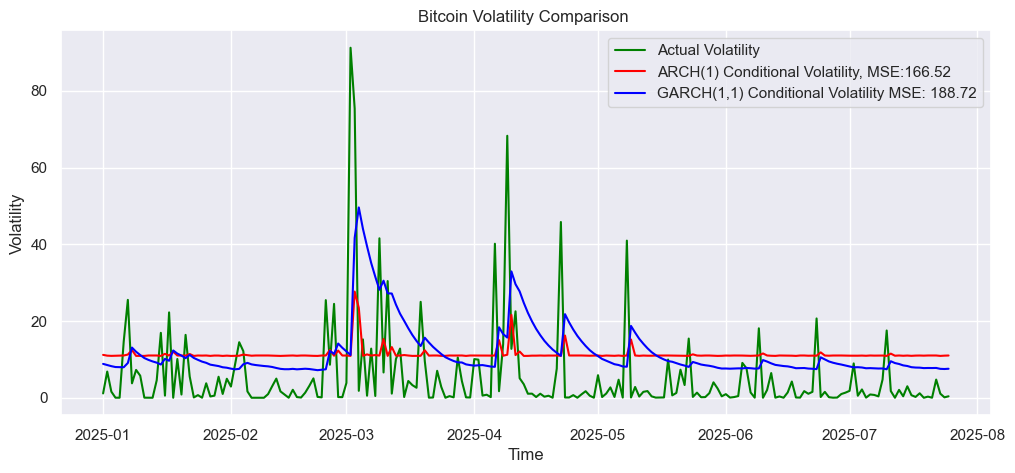

In [98]:
plt.figure(figsize=(12,5))
plt.plot(df.BTC_sq_returns[start:end], color='green', label='Actual Volatility')
plt.plot(results_BTC_arch_1.conditional_volatility, color='red', label='ARCH(1) Conditional Volatility, MSE:' + str(mse_arch_vol.round(2)))
plt.plot(results_BTC_garch_1_1.conditional_volatility, color = 'blue', label = "GARCH(1,1) Conditional Volatility MSE: " + str(mse_garch_vol.round(2)))
plt.title('Bitcoin Volatility Comparison ')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

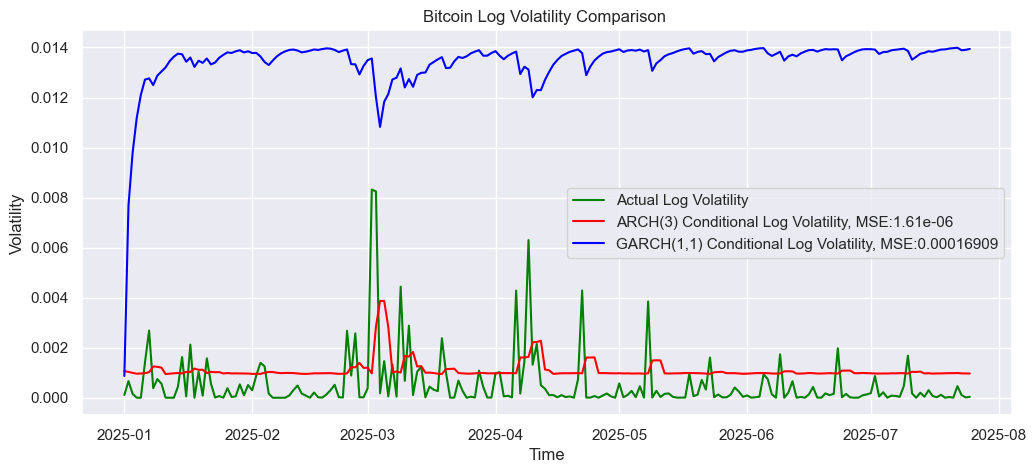

In [99]:
plt.figure(figsize=(12,5))
plt.plot(df.BTC_sq_log_returns[start:end], color='green', label='Actual Log Volatility')
plt.plot(results_BTC_log_arch_3.conditional_volatility, color='red', label='ARCH(3) Conditional Log Volatility, MSE:' + str(mse_arch_log_vol.round(8)))
plt.plot(results_BTC_log_garch_1_1.conditional_volatility, color = 'blue', label = "GARCH(1,1) Conditional Log Volatility, MSE:" + str(mse_garch_log_vol.round(8)))
plt.title('Bitcoin Log Volatility Comparison ')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

In [100]:
print("LLR Test between ARCH(1) and GARCH(1,1) for Volatility: " + str(LLR_test(BTC_arch_1, BTC_garch_1_1)))

LLR Test between ARCH(1) and GARCH(1,1) for Volatility: 1.3471e-06


In [103]:
print("LLR Test between ARCH(1) and GARCH(1,1) for Log Volatility: " + str(LLR_test(BTC_log_garch_1_1,BTC_log_arch_3, DF = 1)))

LLR Test between ARCH(1) and GARCH(1,1) for Log Volatility: 0.0


C:\Users\jcush\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [ ]:
# This tells us that when modeling Volatility GARCH(1,1) is our best model for voloatility and ARCH(3) for log volatility 

## Residuals for GARCH(1,1) Volatility Model using Returns Squared

In [ ]:
#extract residuals and exmaine if they follow white noise to validate the model
# For This section we are looking at ARCH(1) and GARCH(1,1)

In [104]:
df["res_vol_garch_1_1"] = results_BTC_garch_1_1.resid[1:].dropna()
df["std_res_vol_garch_1_1"] = results_BTC_garch_1_1.std_resid[1:].dropna()
df["std_res_sq_vol_garch_1_1"] = results_BTC_garch_1_1.std_resid[1:].pow(2).dropna()

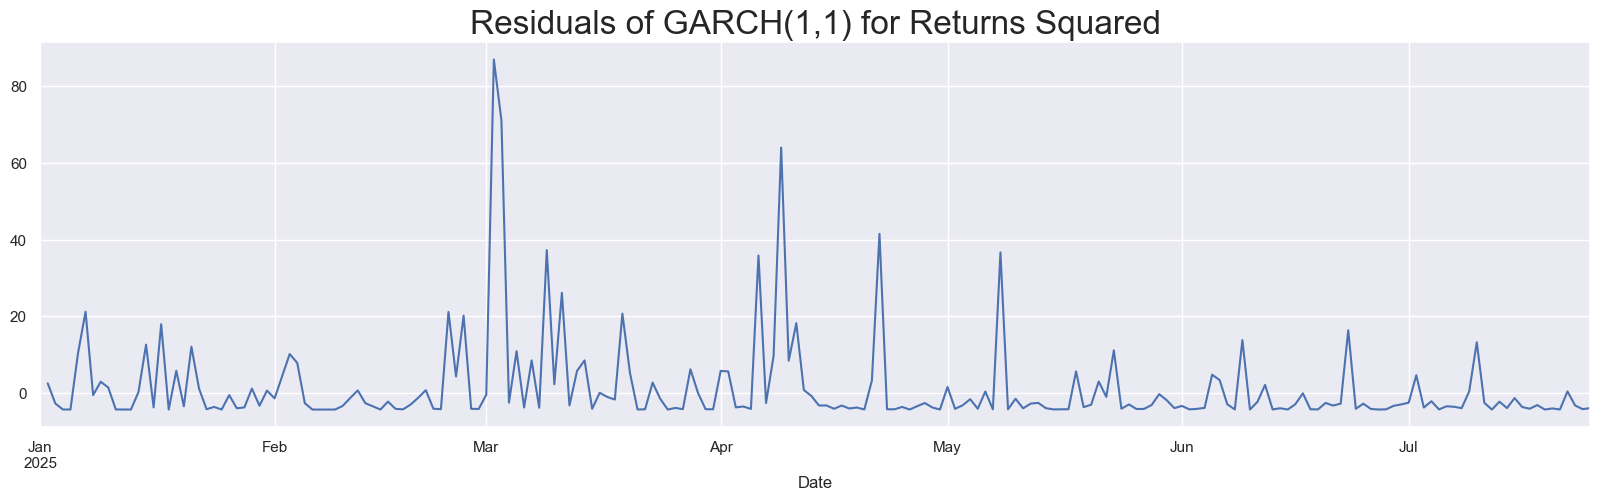

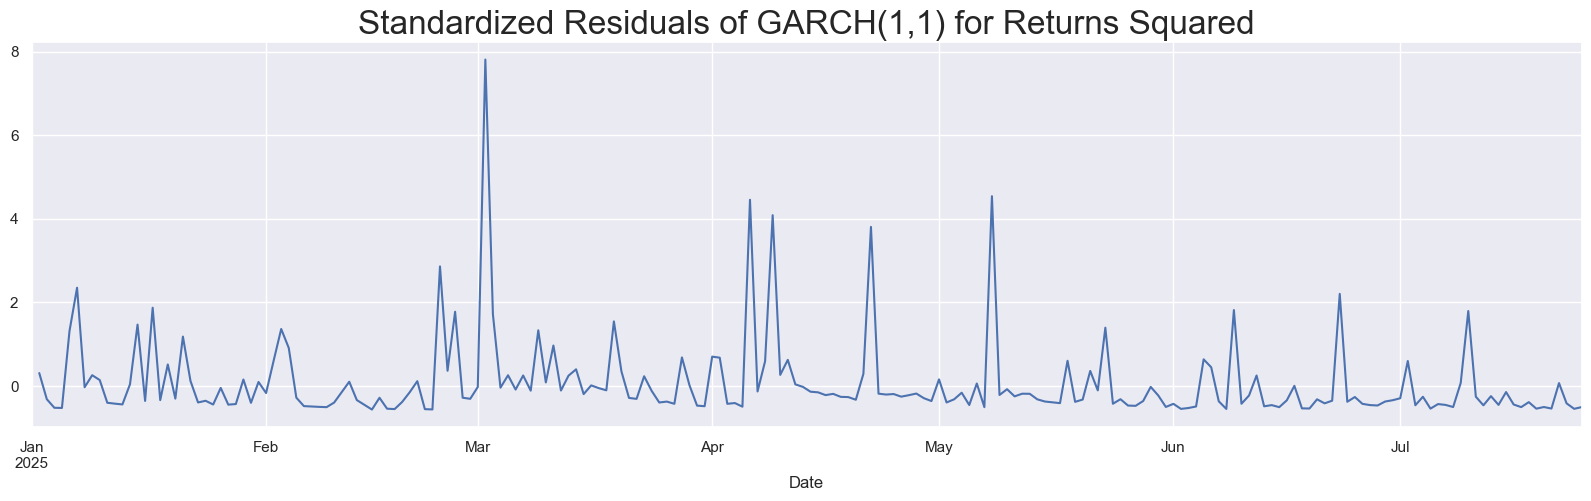

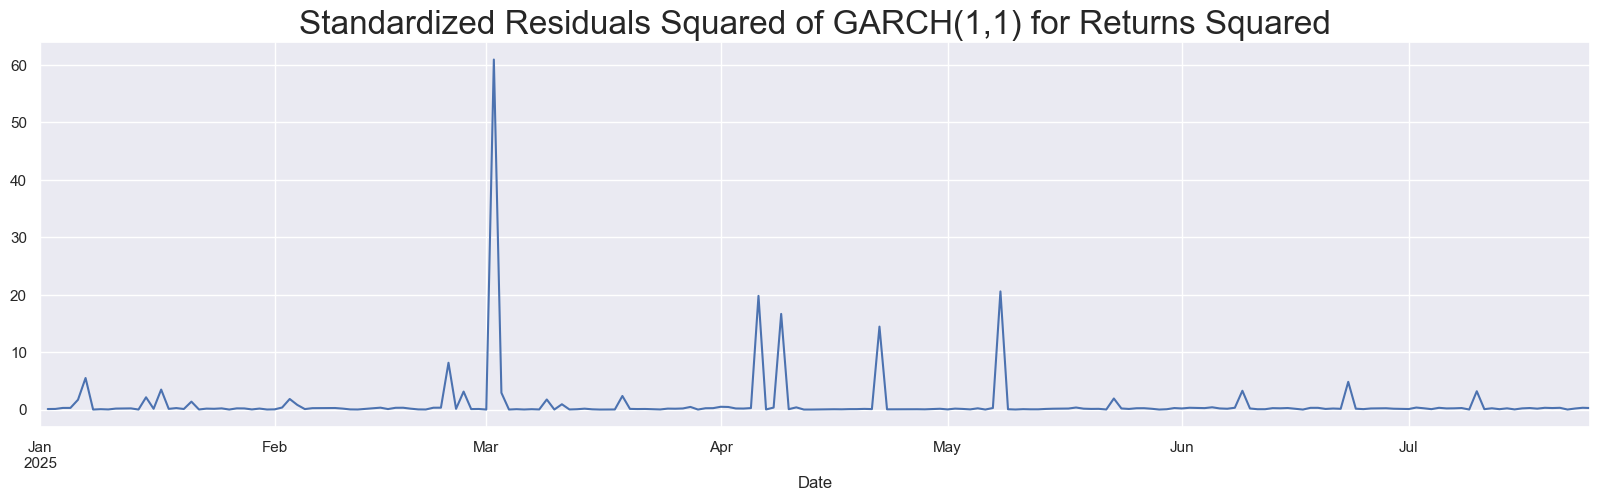

In [105]:
df.res_vol_garch_1_1[start:end].plot(figsize = (20,5))
plt.title("Residuals of GARCH(1,1) for Returns Squared",size = 24)
plt.show()

df.std_res_vol_garch_1_1[start:end].plot(figsize = (20,5))
plt.title("Standardized Residuals of GARCH(1,1) for Returns Squared",size = 24)
plt.show()

df.std_res_sq_vol_garch_1_1[start:end].plot(figsize = (20,5))
plt.title("Standardized Residuals Squared of GARCH(1,1) for Returns Squared",size = 24)
plt.show()

In [106]:
#Next look into ACF and PACF to see if there is any autocorrelation left over

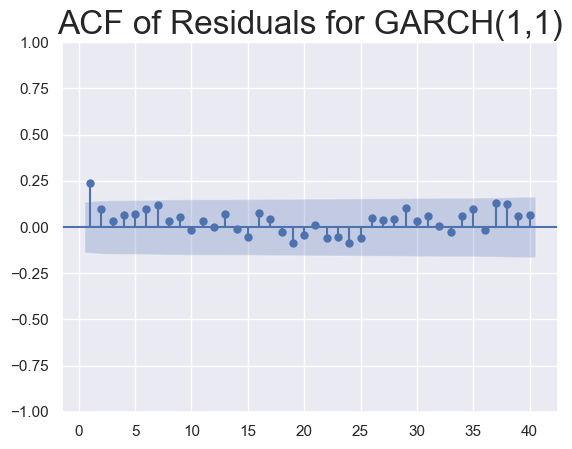

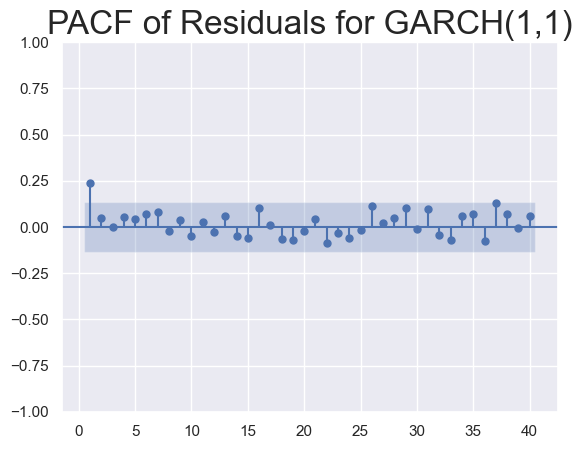

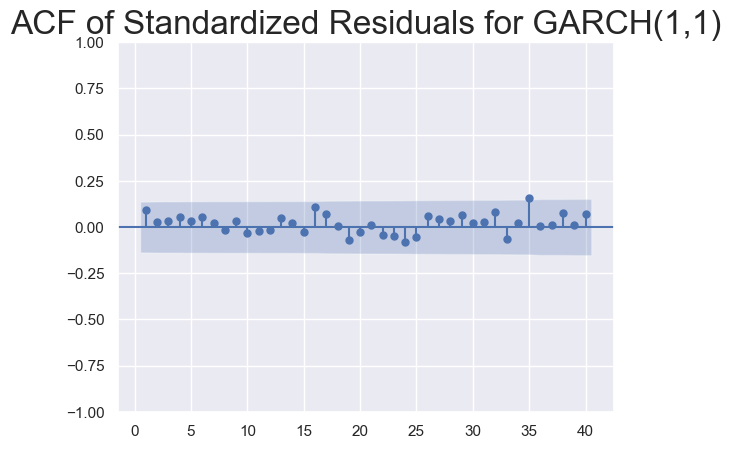

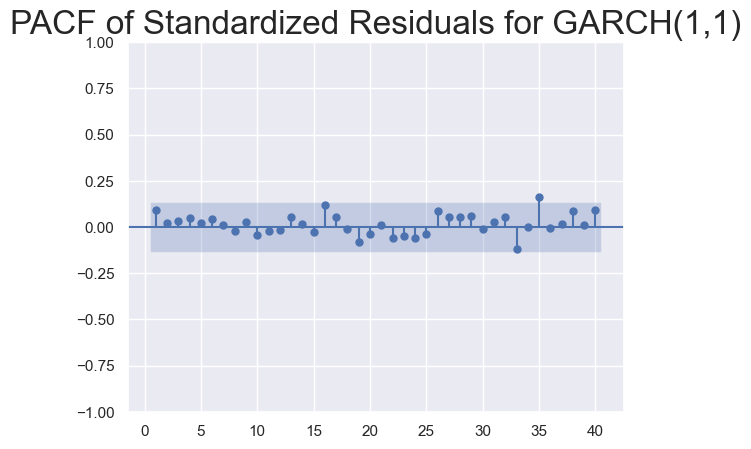

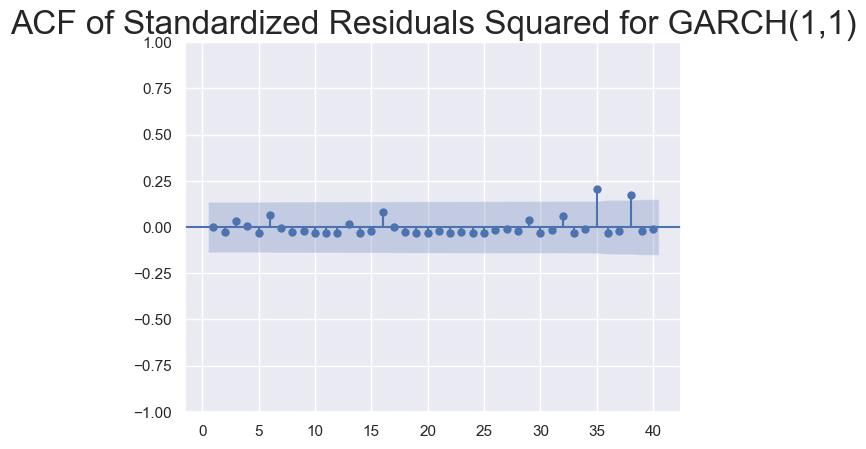

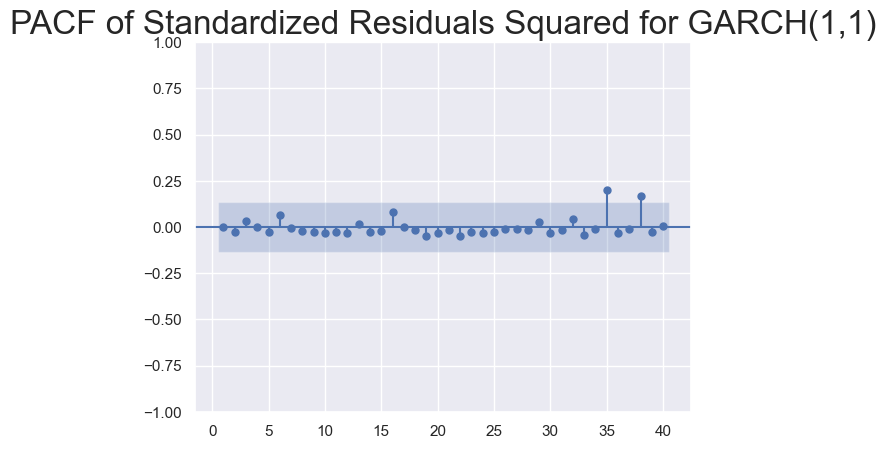

In [107]:
sgt.plot_acf(df.res_vol_garch_1_1.dropna(), zero = False, lags = 40)
plt.title("ACF of Residuals for GARCH(1,1)", size = 24)
plt.show()

sgt.plot_pacf(df.res_vol_garch_1_1.dropna(), zero = False, lags = 40)
plt.title("PACF of Residuals for GARCH(1,1)", size = 24)
plt.show()

sgt.plot_acf(df.std_res_vol_garch_1_1.dropna(), zero = False, lags = 40)
plt.title("ACF of Standardized Residuals for GARCH(1,1)", size = 24)
plt.show()

sgt.plot_pacf(df.std_res_vol_garch_1_1.dropna(), zero = False, lags = 40)
plt.title("PACF of Standardized Residuals for GARCH(1,1)", size = 24)
plt.show()

sgt.plot_acf(df.std_res_sq_vol_garch_1_1.dropna(), zero = False, lags = 40)
plt.title("ACF of Standardized Residuals Squared for GARCH(1,1)", size = 24)
plt.show()

sgt.plot_pacf(df.std_res_sq_vol_garch_1_1.dropna(), zero = False, lags = 40)
plt.title("PACF of Standardized Residuals Squared for GARCH(1,1)", size = 24)
plt.show()

## Residuals for ARCH(3) Volatility Model using Log Returns Squared

In [108]:
df["res_log_vol_arch_3"] = results_BTC_log_arch_3.resid[1:]
df["std_res_log_vol_arch_3"] = results_BTC_log_arch_3.std_resid[1:]
df["std_res_sq_log_vol_arch_3"] = results_BTC_log_arch_3.std_resid[1:].pow(2)

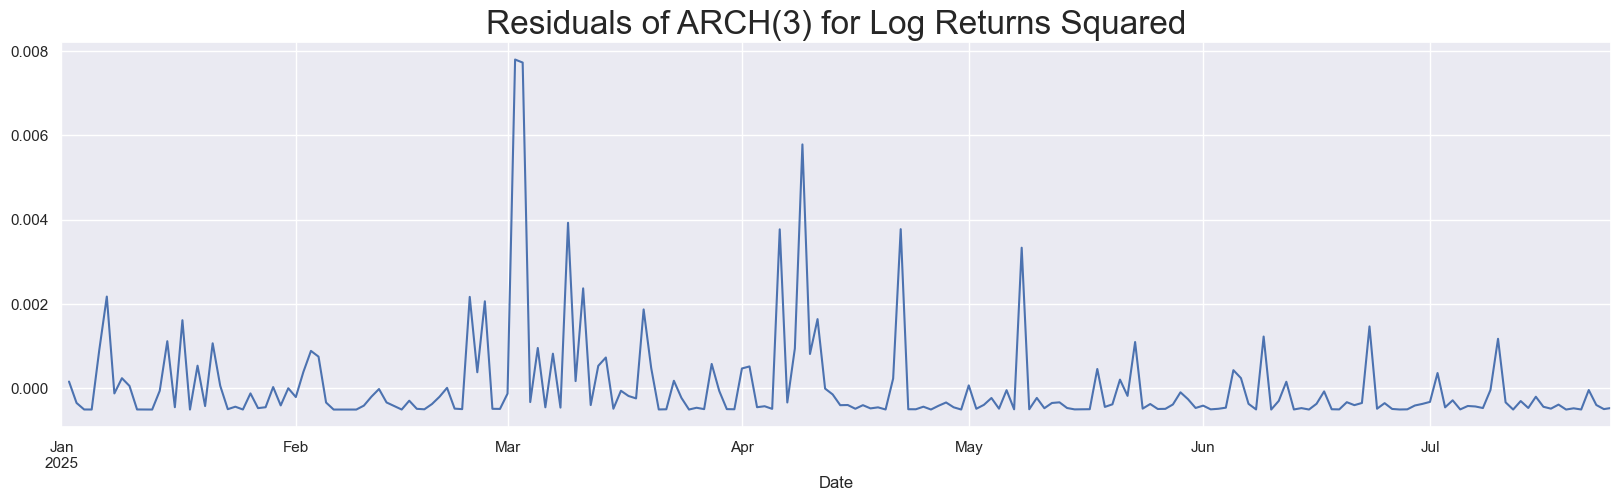

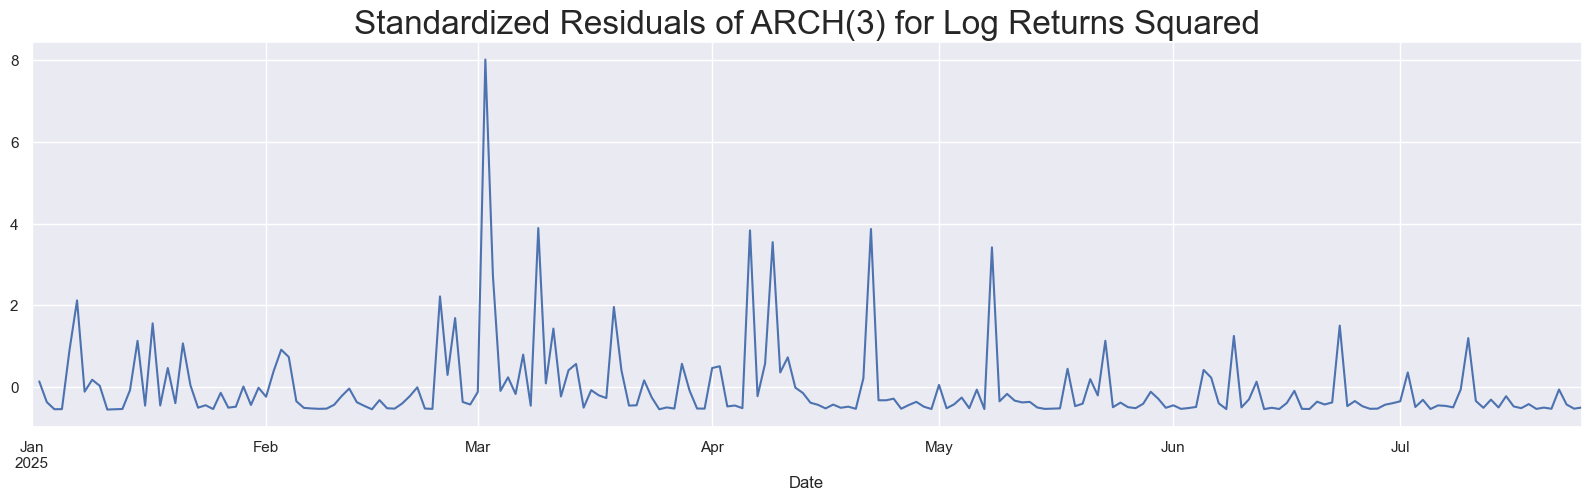

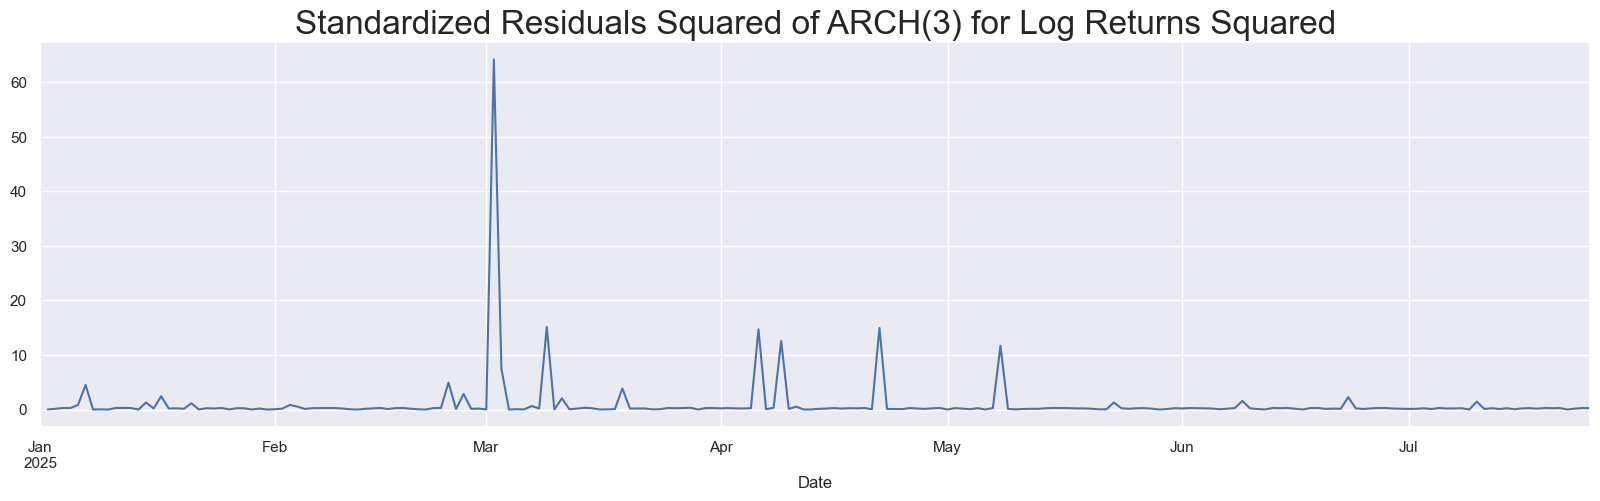

In [109]:
df.res_log_vol_arch_3[start:end].plot(figsize = (20,5))
plt.title("Residuals of ARCH(3) for Log Returns Squared",size = 24)
plt.show()

df.std_res_log_vol_arch_3[start:end].plot(figsize = (20,5))
plt.title("Standardized Residuals of ARCH(3) for Log Returns Squared",size = 24)
plt.show()

df.std_res_sq_log_vol_arch_3[start:end].plot(figsize = (20,5))
plt.title("Standardized Residuals Squared of ARCH(3) for Log Returns Squared",size = 24)
plt.show()

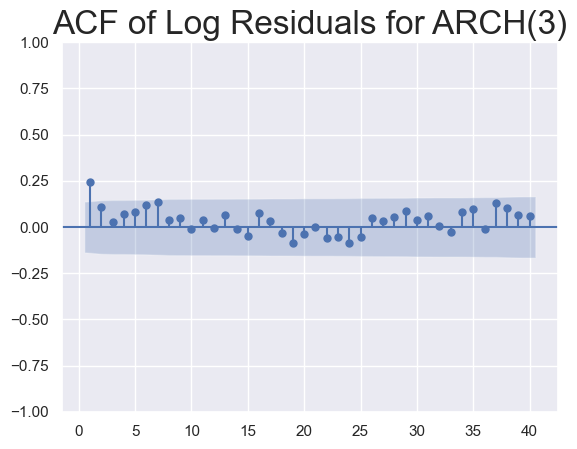

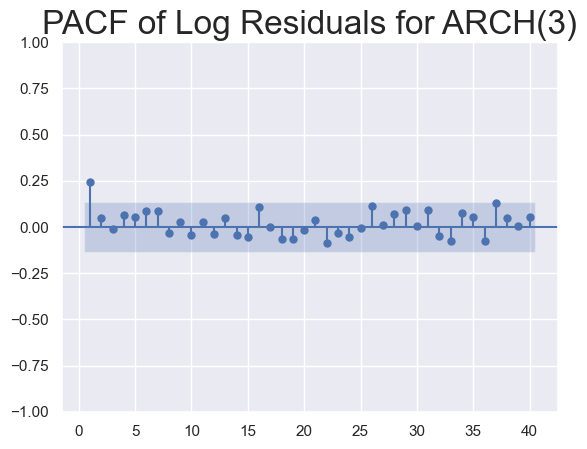

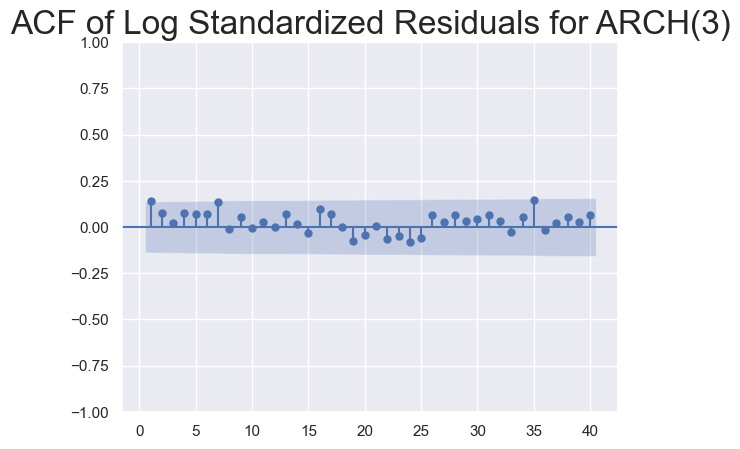

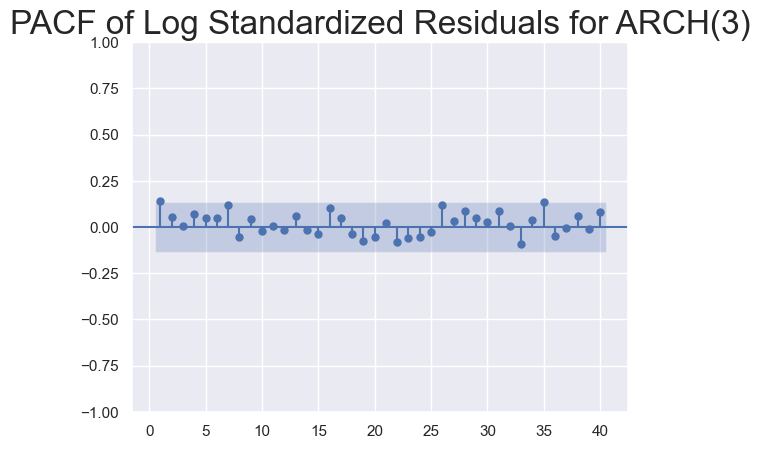

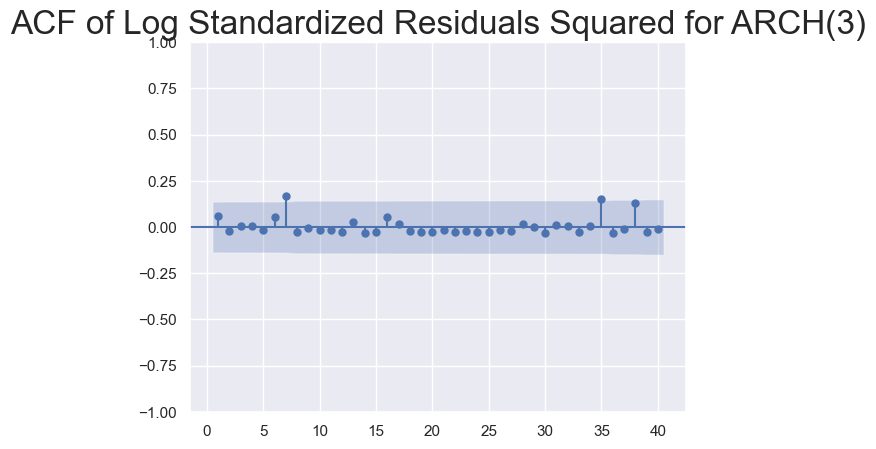

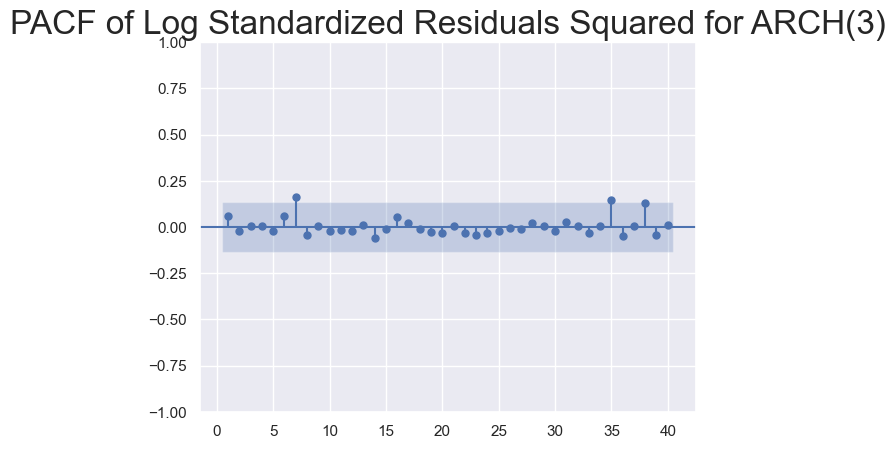

In [110]:
sgt.plot_acf(df.res_log_vol_arch_3.dropna(), zero = False, lags = 40)
plt.title("ACF of Log Residuals for ARCH(3)", size = 24)
plt.show()

sgt.plot_pacf(df.res_log_vol_arch_3.dropna(), zero = False, lags = 40)
plt.title("PACF of Log Residuals for ARCH(3)", size = 24)
plt.show()

sgt.plot_acf(df.std_res_log_vol_arch_3.dropna(), zero = False, lags = 40)
plt.title("ACF of Log Standardized Residuals for ARCH(3)", size = 24)
plt.show()

sgt.plot_pacf(df.std_res_log_vol_arch_3.dropna(), zero = False, lags = 40)
plt.title("PACF of Log Standardized Residuals for ARCH(3)", size = 24)
plt.show()

sgt.plot_acf(df.std_res_sq_log_vol_arch_3.dropna(), zero = False, lags = 40)
plt.title("ACF of Log Standardized Residuals Squared for ARCH(3)", size = 24)
plt.show()

sgt.plot_pacf(df.std_res_sq_log_vol_arch_3.dropna(), zero = False, lags = 40)
plt.title("PACF of Log Standardized Residuals Squared for ARCH(3)", size = 24)
plt.show()

## Ljung Box Test for Residuals

In [111]:
#ACF and PACF show no signs of autocorrelation left over
#lastly, the ljung box test will be used to assess if their is any autocorrelation left over from the model
#if p value is > 0.05 we can assume their is no autocorrealtion left over 

ljung_resid_garch_1_1 = acorr_ljungbox(df.res_vol_garch_1_1.dropna(), lags=20, return_df=True)
print("ljung on GARCH(1,1) Volatility residuals:\n", ljung_resid_garch_1_1)

ljung on GARCH(1,1) Volatility residuals:
       lb_stat  lb_pvalue
1   11.542851   0.000680
2   13.607706   0.001109
3   13.844311   0.003125
4   14.678828   0.005416
5   15.722613   0.007682
6   17.760732   0.006859
7   20.915418   0.003897
8   21.170714   0.006708
9   21.854656   0.009351
10  21.919532   0.015520
11  22.168856   0.023097
12  22.170049   0.035658
13  23.198714   0.039353
14  23.218098   0.056812
15  23.828334   0.068067
16  25.038111   0.069156
17  25.412852   0.085843
18  25.600448   0.109251
19  27.257100   0.098806
20  27.685598   0.117053


In [112]:
ljung_std_resid_garch_1_1 = acorr_ljungbox(df.std_res_vol_garch_1_1.dropna(), lags=20, return_df=True)
print("ljung on GARCH(1,1) standardized Volatility residuals:\n", ljung_std_resid_garch_1_1)

ljung on GARCH(1,1) standardized Volatility residuals:
       lb_stat  lb_pvalue
1    1.667652   0.196573
2    1.838800   0.398758
3    2.089059   0.554129
4    2.741124   0.602038
5    2.972887   0.704166
6    3.567193   0.735010
7    3.668605   0.817058
8    3.714744   0.881900
9    3.931092   0.915889
10   4.182794   0.938724
11   4.306540   0.960077
12   4.372308   0.975743
13   4.955616   0.976157
14   5.055321   0.985028
15   5.188642   0.990405
16   7.838389   0.953532
17   9.014870   0.939794
18   9.022115   0.959228
19  10.089033   0.950715
20  10.288281   0.962638


In [113]:
ljung_std_resid_sq_garch_1_1 = acorr_ljungbox(df.std_res_sq_vol_garch_1_1.dropna(), lags=20, return_df=True)
print("ljung on GARCH(1,1) standardized Volatility residuals squared:\n", ljung_std_resid_sq_garch_1_1)

ljung on GARCH(1,1) standardized Volatility residuals squared:
      lb_stat  lb_pvalue
1   0.001220   0.972134
2   0.156039   0.924946
3   0.346861   0.950987
4   0.349495   0.986399
5   0.545313   0.990370
6   1.458922   0.962176
7   1.464939   0.983499
8   1.639127   0.990150
9   1.744695   0.994892
10  1.942545   0.996762
11  2.158635   0.997856
12  2.357279   0.998629
13  2.435378   0.999324
14  2.652300   0.999546
15  2.774404   0.999753
16  4.340478   0.998180
17  4.340541   0.999108
18  4.476398   0.999470
19  4.745280   0.999613
20  4.968038   0.999736


In [114]:
ljung_log_resid_arch_3 = acorr_ljungbox(df.res_log_vol_arch_3.dropna(), lags=20, return_df=True)
print("ljung on ARCH(3) Log Volatility residuals:\n", ljung_log_resid_arch_3)

ljung_log_std_resid_arch_3 = acorr_ljungbox(df.std_res_log_vol_arch_3.dropna(), lags=20, return_df=True)
print("ljung on ARCH(3) standardized Log Volatility residuals:\n", ljung_log_std_resid_arch_3)

ljung_log_std_resid_sq_arch_3 = acorr_ljungbox(df.std_res_sq_log_vol_arch_3.dropna(), lags=20, return_df=True)
print("ljung on ARCH(1,1) standardized Log Volatility residuals squared:\n", ljung_log_std_resid_sq_arch_3)

ljung on ARCH(3) Log Volatility residuals:
       lb_stat  lb_pvalue
1   12.360181   0.000439
2   14.781717   0.000617
3   14.953495   0.001857
4   16.067365   0.002930
5   17.511196   0.003626
6   20.647305   0.002122
7   24.683574   0.000863
8   24.967920   0.001574
9   25.451679   0.002510
10  25.485864   0.004497
11  25.846675   0.006840
12  25.854087   0.011256
13  26.764695   0.013397
14  26.785151   0.020529
15  27.347672   0.026028
16  28.553460   0.027127
17  28.830913   0.036117
18  29.041503   0.047874
19  30.660257   0.043974
20  31.027916   0.054823
ljung on ARCH(3) standardized Log Volatility residuals:
       lb_stat  lb_pvalue
1    4.026915   0.044780
2    5.147816   0.076237
3    5.264031   0.153453
4    6.532460   0.162757
5    7.596561   0.179916
6    8.640111   0.194852
7   12.637886   0.081438
8   12.663139   0.123978
9   13.264921   0.150981
10  13.267004   0.209124
11  13.433971   0.265910
12  13.434399   0.338273
13  14.476694   0.341149
14  14.534772   0.410677

In [ ]:
# after standardization both models have residuals that return p-values > 0.05 which means for std_residuals, 
# the ljung box test helps us conclude that near all autocorrelation has been captured in  our model, 
# and the standardized residuals squared p values help us conclude that the models captured conditional heteroskedasticity well

In [116]:
# A useful application of this project is to see how well it forecasts volatility over the next month and compare against what actually happens 